## Importing Library

In [1]:
import numpy as np 
import pandas as pd 
import nltk
import os
import gc
from keras.preprocessing import sequence,text
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense,Dropout,Embedding,LSTM,Conv1D,GlobalMaxPooling1D,Flatten,MaxPooling1D,GRU,SpatialDropout1D,Bidirectional
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,f1_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
#pd.set_option('display.max_colwidth',100)
pd.set_option('display.max_colwidth', -1)

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
gc.collect()

0

### Loading dataset and basic visualization

In [3]:
train=pd.read_csv('../input/movie-review-sentiment-analysis-kernels-only/train.tsv',sep='\t')
print(train.shape)
train.head()

(156060, 4)


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,"A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .",1
1,2,1,A series of escapades demonstrating the adage that what is good for the goose,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [4]:
test=pd.read_csv('../input/movie-review-sentiment-analysis-kernels-only/test.tsv',sep='\t')
print(test.shape)
test.head()

(66292, 3)


,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine effort .
1,156062,8545,An intermittently pleasing but mostly routine effort
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [5]:
sub=pd.read_csv('../input/movie-review-sentiment-analysis-kernels-only/sampleSubmission.csv')
sub.head()

,PhraseId,Sentiment
0,156061,2
1,156062,2
2,156063,2
3,156064,2
4,156065,2


**Adding Sentiment column to test datset and joing train and test for preprocessing**

In [6]:
test['Sentiment']=-999
test.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,156061,8545,An intermittently pleasing but mostly routine effort .,-999
1,156062,8545,An intermittently pleasing but mostly routine effort,-999
2,156063,8545,An,-999
3,156064,8545,intermittently pleasing but mostly routine effort,-999
4,156065,8545,intermittently pleasing but mostly routine,-999


In [7]:
df=pd.concat([train,test],ignore_index=True)
print(df.shape)
df.tail()

(222352, 4)


,PhraseId,SentenceId,Phrase,Sentiment
222347,222348,11855,"A long-winded , predictable scenario .",-999
222348,222349,11855,"A long-winded , predictable scenario",-999
222349,222350,11855,"A long-winded ,",-999
222350,222351,11855,A long-winded,-999
222351,222352,11855,predictable scenario,-999


In [8]:
del train,test
gc.collect()

26

** cleaning review**

In [9]:
from nltk.tokenize import word_tokenize
from nltk import FreqDist
from nltk.stem import SnowballStemmer,WordNetLemmatizer
stemmer=SnowballStemmer('english')
lemma=WordNetLemmatizer()
from string import punctuation
import re


In [10]:
def clean_review(review_col):
    review_corpus=[]
    for i in range(0,len(review_col)):
        review=str(review_col[i])
        review=re.sub('[^a-zA-Z]',' ',review)
        #review=[stemmer.stem(w) for w in word_tokenize(str(review).lower())]
        review=[lemma.lemmatize(w) for w in word_tokenize(str(review).lower())]
        review=' '.join(review)
        review_corpus.append(review)
    return review_corpus

In [11]:
df['clean_review']=clean_review(df.Phrase.values)
df.head()


,PhraseId,SentenceId,Phrase,Sentiment,clean_review
0,1,1,"A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .",1,a series of escapade demonstrating the adage that what is good for the goose is also good for the gander some of which occasionally amuses but none of which amount to much of a story
1,2,1,A series of escapades demonstrating the adage that what is good for the goose,2,a series of escapade demonstrating the adage that what is good for the goose
2,3,1,A series,2,a series
3,4,1,A,2,a
4,5,1,series,2,series


** seperating train and test dataset**

In [12]:
df_train=df[df.Sentiment!=-999]
df_train.shape

(156060, 5)

In [13]:
df_test=df[df.Sentiment==-999]
df_test.drop('Sentiment',axis=1,inplace=True)
print(df_test.shape)
df_test.head()

(66292, 4)


,PhraseId,SentenceId,Phrase,clean_review
156060,156061,8545,An intermittently pleasing but mostly routine effort .,an intermittently pleasing but mostly routine effort
156061,156062,8545,An intermittently pleasing but mostly routine effort,an intermittently pleasing but mostly routine effort
156062,156063,8545,An,an
156063,156064,8545,intermittently pleasing but mostly routine effort,intermittently pleasing but mostly routine effort
156064,156065,8545,intermittently pleasing but mostly routine,intermittently pleasing but mostly routine


In [14]:
del df
gc.collect()

23

### Splitting Train dataset into train and 20% validation set

In [15]:
train_text=df_train.clean_review.values
test_text=df_test.clean_review.values
target=df_train.Sentiment.values
y=to_categorical(target)
print(train_text.shape,target.shape,y.shape)

(156060,) (156060,) (156060, 5)


In [16]:
X_train_text,X_val_text,y_train,y_val=train_test_split(train_text,y,test_size=0.2,stratify=y,random_state=123)
print(X_train_text.shape,y_train.shape)
print(X_val_text.shape,y_val.shape)

(124848,) (124848, 5)
(31212,) (31212, 5)


### Finding number of unique words in train set

In [17]:
all_words=' '.join(X_train_text)
all_words=word_tokenize(all_words)
dist=FreqDist(all_words)
num_unique_word=len(dist)
num_unique_word

13732

### Finding max length of a review in train set

In [18]:
r_len=[]
for text in X_train_text:
    word=word_tokenize(text)
    l=len(word)
    r_len.append(l)
    
MAX_REVIEW_LEN=np.max(r_len)
MAX_REVIEW_LEN

48

## Building Keras LSTM model

In [19]:
max_features = num_unique_word
max_words = MAX_REVIEW_LEN
batch_size = 128
epochs = 3
num_classes=5

** Tokenize Text**

In [20]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train_text))
X_train = tokenizer.texts_to_sequences(X_train_text)
X_val = tokenizer.texts_to_sequences(X_val_text)
X_test = tokenizer.texts_to_sequences(test_text)

** sequence padding**

In [21]:
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_val = sequence.pad_sequences(X_val, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)
print(X_train.shape,X_val.shape,X_test.shape)

(124848, 48) (31212, 48) (66292, 48)


In [24]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

## 5. Glove word embedding

In [22]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')
    
def get_embed_mat(EMBEDDING_FILE, max_features,embed_dim):
    # word vectors
    embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE, encoding='utf8'))
    print('Found %s word vectors.' % len(embeddings_index))

    # embedding matrix
    word_index = tokenizer.word_index
    num_words = min(max_features, len(word_index) + 1)
    all_embs = np.stack(embeddings_index.values()) #for random init
    embedding_matrix = np.random.normal(all_embs.mean(), all_embs.std(), 
                                        (num_words, embed_dim))
    for word, i in word_index.items():
        if i >= max_features:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    max_features = embedding_matrix.shape[0]
    
    return embedding_matrix

In [23]:
# embedding matrix
EMBEDDING_FILE = '../input/glove6b100dtxt/glove.6B.100d.txt'
embed_dim = 100 #word vector dim
embedding_matrix = get_embed_mat(EMBEDDING_FILE,max_features,embed_dim)
print(embedding_matrix.shape)

Found 400000 word vectors.
(13732, 100)


In [ ]:
model5 = Sequential()
model5.add(Embedding(max_features, embed_dim, input_length=X_train.shape[1],weights=[embedding_matrix],trainable=True))
model5.add(SpatialDropout1D(0.25))
model5.add(Bidirectional(GRU(128,return_sequences=True)))
model5.add(Bidirectional(GRU(64,return_sequences=False)))
model5.add(Dropout(0.5))
model5.add(Dense(num_classes, activation='softmax'))
model5.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model5.summary()

In [ ]:
%%time
history5=model5.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=4, batch_size=batch_size, verbose=1)

In [ ]:
plot_model_history(history5)

In [ ]:
y_pred5=model5.predict_classes(X_test, verbose=1)

In [ ]:
sub.Sentiment=y_pred5
sub.to_csv('sub5.csv',index=False)
sub.head()

In [25]:
model6 = Sequential()
model6.add(Embedding(max_features, embed_dim, input_length=X_train.shape[1],weights=[embedding_matrix],trainable=True))
model6.add(SpatialDropout1D(0.25))
model6.add(Bidirectional(GRU(128,return_sequences=True)))
model6.add(Conv1D(128,kernel_size=3,padding='same',activation='relu'))
model6.add(Conv1D(128,kernel_size=3,padding='same',activation='relu'))
model6.add(GlobalMaxPooling1D())
model6.add(Dropout(0.5))
model6.add(Dense(num_classes, activation='softmax'))
model6.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model6.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 48, 100)           1373200   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 48, 100)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 48, 256)           175872    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 48, 128)           98432     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 48, 128)           49280     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
__________

In [26]:
%%time
history6=model6.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=4, batch_size=batch_size, verbose=1)

Train on 124848 samples, validate on 31212 samples
Epoch 1/4
124848/124848 [==============================] - 138s 1ms/step - loss: 1.0020 - acc: 0.5908 - val_loss: 0.8591 - val_acc: 0.6465
Epoch 2/4
124848/124848 [==============================] - 134s 1ms/step - loss: 0.8515 - acc: 0.6463 - val_loss: 0.8045 - val_acc: 0.6702
Epoch 3/4
124848/124848 [==============================] - 134s 1ms/step - loss: 0.7899 - acc: 0.6721 - val_loss: 0.7830 - val_acc: 0.6753
Epoch 4/4
124848/124848 [==============================] - 134s 1ms/step - loss: 0.7482 - acc: 0.6878 - val_loss: 0.7736 - val_acc: 0.6811
CPU times: user 10min 57s, sys: 37.7 s, total: 11min 35s
Wall time: 9min 1s


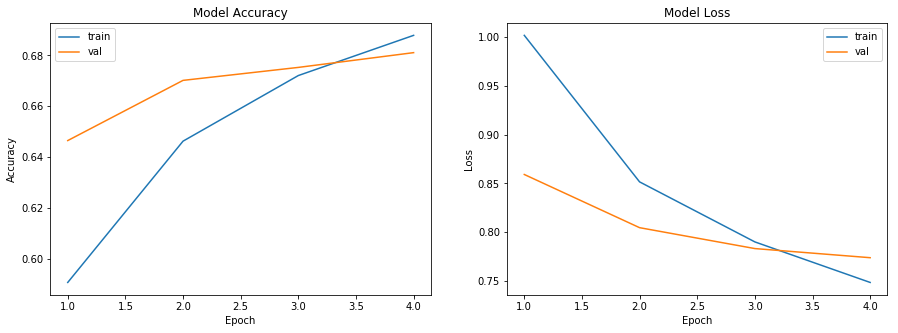

In [27]:
plot_model_history(history6)

In [ ]:
y_pred6=model6.predict_classes(X_test, verbose=1)

sub.Sentiment=y_pred6
sub.to_csv('sub6.csv',index=False)
sub.head()